# ARIMA
---
By richie

In [7]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [8]:
# Load the dataset
file_path = 'data.csv'
df = pd.read_csv(file_path)

In [9]:
# Convert the 'Statistical Period' to datetime and set as index
df['Statistical Period'] = pd.to_datetime(df['Statistical Period'])
df.set_index('Statistical Period', inplace=True)

In [10]:
# Select 'PV Yield (kWh)' column for forecasting and handle missing values
solar_power_data = df['PV Yield (kWh)'].fillna(method='ffill')
solar_power_data

/var/folders/pd/qsy0fv9j0ts43m9j8cbg5r5r0000gn/T/ipykernel_34791/2837476835.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  solar_power_data = df['PV Yield (kWh)'].fillna(method='ffill')


Statistical Period
2023-05-18 23:00:00    0.00
2023-05-19 00:00:00    0.00
2023-05-19 01:00:00    0.00
2023-05-19 02:00:00    0.00
2023-05-19 03:00:00    0.00
                       ... 
2024-09-06 19:00:00    0.55
2024-09-06 20:00:00    0.55
2024-09-06 21:00:00    0.55
2024-09-06 22:00:00    0.55
2024-09-06 23:00:00    0.55
Name: PV Yield (kWh), Length: 10057, dtype: float64

In [11]:
# Check stationarity using the Augmented Dickey-Fuller test
adf_test_result = adfuller(solar_power_data)
if adf_test_result[1] > 0.05:
    print("The series is non-stationary, differencing required.")
else:
    print("The series is stationary, no differencing needed.")

The series is stationary, no differencing needed.


In [12]:
# Define the p, d, q parameters and perform grid search for ARIMA hyperparameter tuning
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
best_aic = np.inf
best_order = None
best_mdl = None

for param in pdq:
    try:
        model = ARIMA(solar_power_data, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = param
            best_mdl = results
    except:
        continue

print(f'Best ARIMA order: {best_order}, AIC: {best_aic}')

/Users/richie/.venv/dev/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/richie/.venv/dev/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/richie/.venv/dev/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/richie/.venv/dev/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Best ARIMA order: (2, 0, 3), AIC: -4301.106751814342


/Users/richie/.venv/dev/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
# Split the data into 80% train and 20% test
train_size = int(len(solar_power_data) * 0.8)
train_data, test_data = solar_power_data[:train_size], solar_power_data[train_size:]

In [14]:
# Fit the ARIMA model on the training data
model = ARIMA(train_data, order=best_order)
model_fit = model.fit()
print(model_fit.summary())

/Users/richie/.venv/dev/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/richie/.venv/dev/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/richie/.venv/dev/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         PV Yield (kWh)   No. Observations:                 8045
Model:                 ARIMA(2, 0, 3)   Log Likelihood                1685.669
Date:                Wed, 16 Oct 2024   AIC                          -3357.337
Time:                        14:46:27   BIC                          -3308.387
Sample:                             0   HQIC                         -3340.587
                               - 8045                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2479      0.006     41.074      0.000       0.236       0.260
ar.L1          1.7445      0.011    159.464      0.000       1.723       1.766
ar.L2         -0.8296      0.011    -77.809      0.0

In [15]:
# Forecast for the same number of steps as the test data
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)

/Users/richie/.venv/dev/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/richie/.venv/dev/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [16]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data, forecast)
print(f'Mean Absolute Error: {mae} kWh')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f'Root Mean Square Error: {rmse} kWh')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data, forecast)
print(f'Mean Squared Error: {mse} kWh')

# If required, you can compare these errors against your desired thresholds:
if mae < 5:
    print("Model MAE is within the acceptable range (< 5 kWh).")
else:
    print("Model MAE exceeds the acceptable range (> 5 kWh).")

if rmse < 10:
    print("Model RMSE is within the acceptable range (< 10 kWh).")
else:
    print("Model RMSE exceeds the acceptable range (> 10 kWh).")

Mean Absolute Error: 0.3396771886069491 kWh
Root Mean Square Error: 0.43983930831816126 kWh
Mean Squared Error: 0.19345861714179854 kWh
Model MAE is within the acceptable range (< 5 kWh).
Model RMSE is within the acceptable range (< 10 kWh).


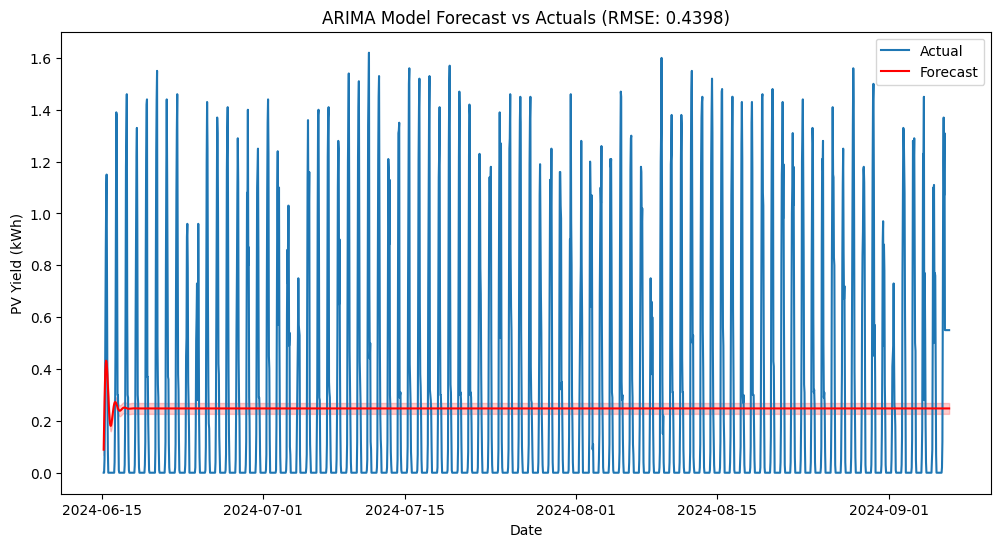

In [17]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label="Actual")
plt.plot(test_data.index, forecast, color='red', label="Forecast")
plt.fill_between(test_data.index, forecast - 1.96 * np.std(forecast), forecast + 1.96 * np.std(forecast), color='red', alpha=0.2)
plt.title(f"ARIMA Model Forecast vs Actuals (RMSE: {rmse:.4f})")
plt.xlabel('Date')
plt.ylabel('PV Yield (kWh)')
plt.legend()
plt.show()